In [2]:
import torch
from torch import nn as nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import DL_project_utils as utils
import dlc_practical_prologue as prologue

%load_ext autoreload
%autoreload 1
%aimport DL_project_utils

In [48]:
class ResNetBlock(nn.Module):
    def __init__(self, nb_channels, kernel_size,
                 skip_connections = True, batch_normalization = True):
        super().__init__()

        self.conv1 = nn.Conv2d(nb_channels, nb_channels,
                               kernel_size = kernel_size,
                               padding = (kernel_size - 1) // 2)

        self.bn1 = nn.BatchNorm2d(nb_channels)

        self.conv2 = nn.Conv2d(nb_channels, nb_channels,
                               kernel_size = kernel_size,
                               padding = (kernel_size - 1) // 2)

        self.bn2 = nn.BatchNorm2d(nb_channels)

        self.skip_connections = skip_connections
        self.batch_normalization = batch_normalization

    def forward(self, x):
        #y = nn.Dropout2d(0.3)(x)
        y = self.conv1(x)
        if self.batch_normalization: y = self.bn1(y)
        y = F.relu(y)
        y = nn.Dropout2d(0.3)(y)
        y = self.conv2(y)
        if self.batch_normalization: y = self.bn2(y)
        if self.skip_connections: y = y + x
        y = F.relu(y)
        

        return y

In [56]:
class ResNet(nn.Module):

    def __init__(self, nb_residual_blocks, nb_channels,
                 kernel_size, nb_classes = 10,
                 skip_connections = True, batch_normalization = True):
        super().__init__()

        self.conv = nn.Conv2d(2, nb_channels,
                              kernel_size = kernel_size,
                              padding = (kernel_size - 1) // 2)
        self.bn = nn.BatchNorm2d(nb_channels)

        self.resnet_blocks = nn.Sequential(
            *(ResNetBlock(nb_channels, kernel_size, skip_connections, batch_normalization)
              for _ in range(nb_residual_blocks))
        )

        self.fc = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(nb_channels, 256),
            nn.Linear(256, nb_classes)
        )

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.resnet_blocks(x)
        x = F.avg_pool2d(x, 14).view(x.size(0), -1)
        x = self.fc(x)
        return x

In [57]:
train_data, test_data = utils.read_input(batch_size=100, single_channel=False, pairs=5000)

In [73]:
epochs, lr, loss, optimizer, batch_size = 50, 1e-2, 'cross_entropy', 'Adam', 500
model = ResNet(nb_residual_blocks = 10, nb_channels = 15,
                   kernel_size = 3, nb_classes = 2)
train_loss, train_acc, val_loss, val_acc = utils.train_model(model, train_dataset=train_data, batch_size=batch_size, learning_rate=lr,
                                                             optimizer=optimizer, loss=loss, epochs=epochs, cuda=True, verbose=False)

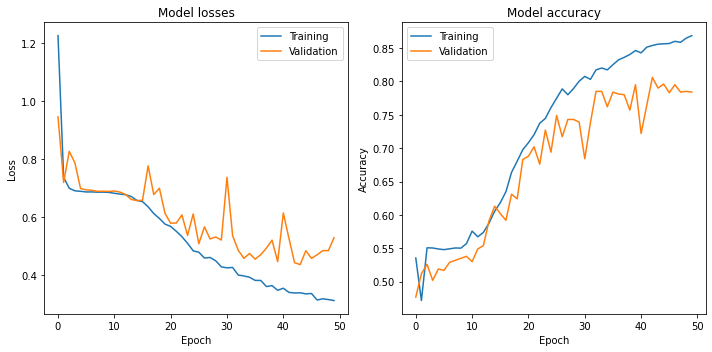

In [74]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model losses')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [75]:
utils.evaluate_model(model, test_data, cuda=True, batch_size=500)

0.7864

In [72]:
test_data.tensors[0].shape

5000

torch.Size([5000, 2])